# Clustering analysis on 10k PBMC data

In [ ]:
from keras.utils.vis_utils import model_to_dot

import tensorflow as tf
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import os, sys

sys.path.append('../src')

from imp import load_source
from models import *
from utils import *

tf.enable_eager_execution()
tf.executing_eagerly()

Using TensorFlow backend.



  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

## Adversarial Autoencoder: Basic Architecture

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

### Build the model

In [4]:
# Network parameters
parameters = {
    'latent_dim': 40,
    'layers_enc_dim': [1000, 500, 300, 200, 100],
    'layers_dec_dim': [100, 200, 300, 500, 1000],
    'layers_dis_dim': [40, 30, 20, 10],
    'batch_size': 1000,
    'epochs': 200
}

In [5]:
model = AAE1(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,35,batch size
epochs,20,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [9]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

if TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    pass

#     strategy = tf.distribute.experimental.CentralStorageStrategy()

#     with strategy.scope():

# #         BATCH_SIZE_PER_REPLICA = model.batch_size
# #         global_batch_size = (BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync)
# #         model.batch_size = global_batch_size
#         model.build_model()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 2145)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          429200      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/AAE1/PBMC10k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE1/PBMC10k/graphs')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model graphs saved.



### Visualize graphs

[ENCODER](../results/AAE1/PBMC10k/graphs/encoder.png)

[DECODER](../results/AAE1/PBMC10k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE1/PBMC10k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE1/PBMC10k/graphs/autoencoder.png)

### Train the model

In [10]:
# Create the input dataset
MODE = 'Dataset'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/pbmc10k.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

Epoch 2/20, rec. loss: 0.928066, dis. loss: 0.214310


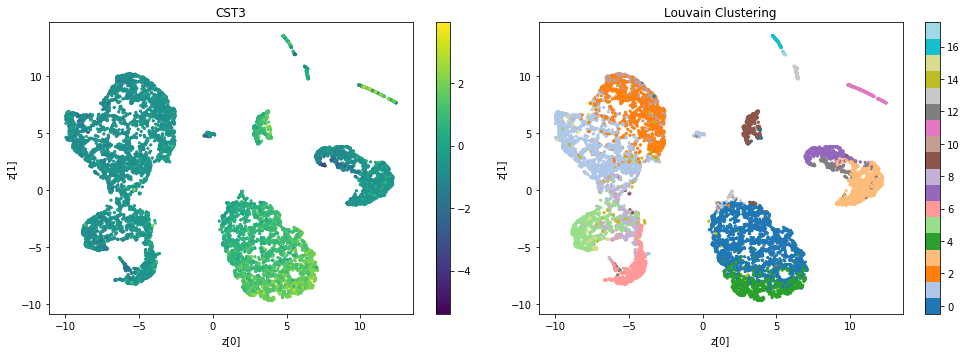

In [ ]:
# Training...

log_dir = '../results/AAE1/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'CST3'  # used only for training visualization

with strategy.scope():
    
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    
    rec_loss, dis_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                 enable_function=True, graph=GRAPH, gene=GENE, 
                                                 log_dir=log_dir)

!tensorboard --logdir=../results/AAE1/PBMC10k/

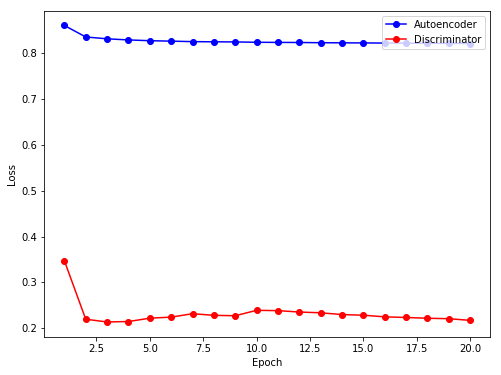

In [13]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range,dis_loss, 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Discriminator'], loc='upper right')
plt.show()

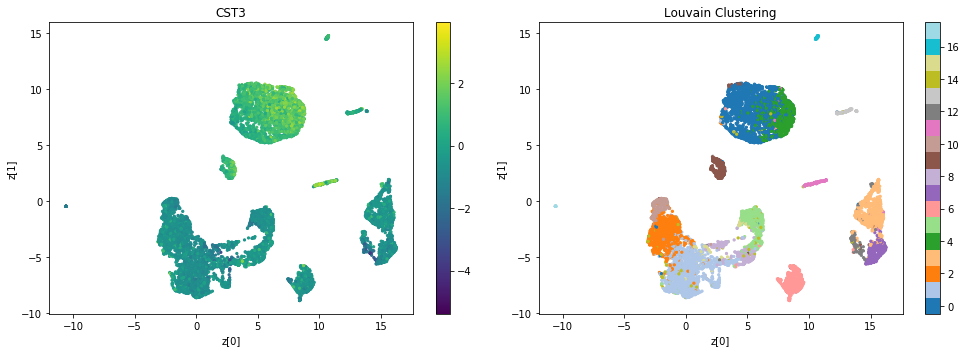

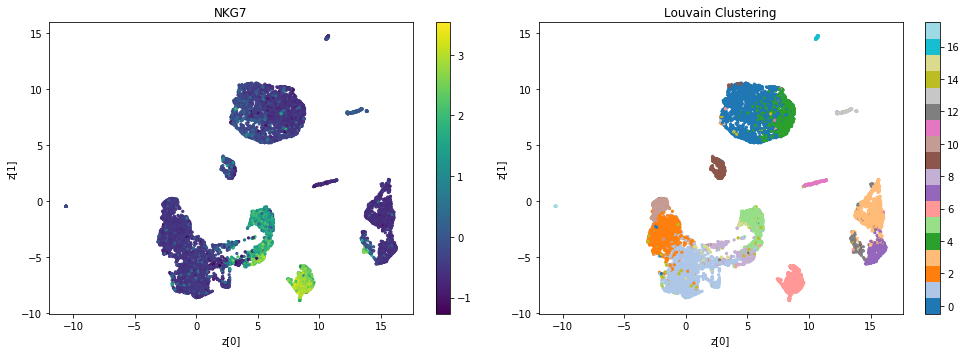

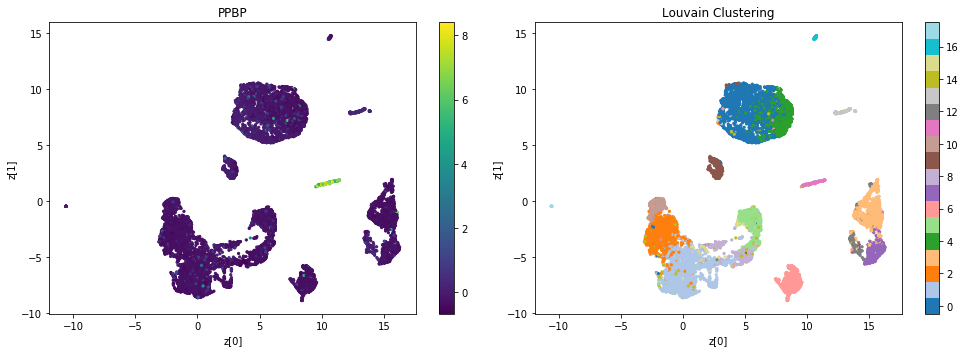

In [14]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

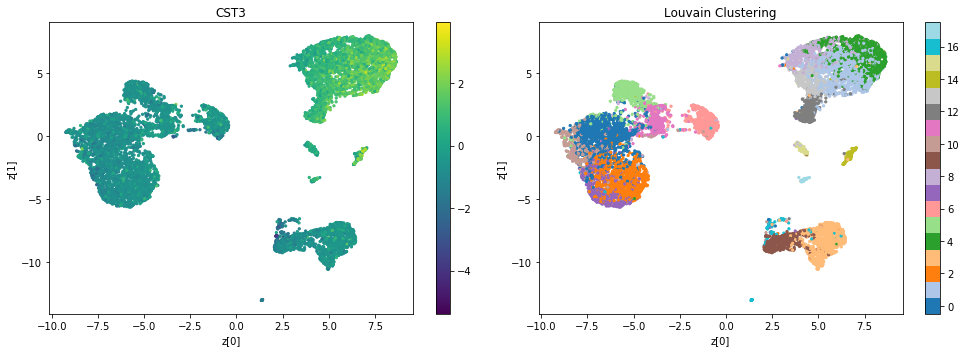

ARI = 0.5022273829847442
AMI = 0.6804878908656923


In [18]:
from tensorflow.keras.models import load_model
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

log_dir = '../results/AAE1/PBMC10k/'
model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

model.update_labels(res=1.0)
labels_pred = model.labels

GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

print("ARI = {}".format(adjusted_rand_score(labels_true, labels_pred)))
print("AMI = {}".format(adjusted_mutual_info_score(labels_true, labels_pred)))

## Unsupervised Adversarial Autoencoder: Setting Number of Clusters

### Build the model

In [5]:
# Network parameters
parameters = {
    'latent_dim': 10,
    'num_clusters': 17,
    'layers_enc_dim': [200, 100, 50, 30],
    'layers_dec_dim': [30, 50, 100, 200],
    'layers_dis_dim': [200, 100, 50, 30],
    'layers_dis_cat_dim': [200, 100, 50, 30],
    'batch_size': 100,
    'epochs': 200,
    'tau': 0.05 # temperature parameter
}

In [6]:
model = AAE2(**parameters)

In [7]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [8]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [9]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,100,batch size
epochs,200,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,10,dimension of latent space Z
layer_1_enc_dim,200,dimension of encoder dense layer 1


In [10]:
# Define distribute strategy and build the full model

TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:

    #     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
    #     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()

    strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)

    with strategy.scope():
        model.build_model()

if TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    pass

#     strategy = tf.distribute.experimental.CentralStorageStrategy()

#     with strategy.scope():

# #         BATCH_SIZE_PER_REPLICA = model.batch_size
# #         global_batch_size = (BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync)
# #         model.batch_size = global_batch_size
#         model.build_model()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [11]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 2145)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 200)          429200      X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 200)          800         H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 200)          0           BN_1[0][0]                       
___________________________________________________________________________

In [ ]:
# Export model graphs

log_dir = '../results/AAE2/PBMC10k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/AAE2/PBMC10k/graphs')

### Visualize graphs

[ENCODER](../results/AAE2/PBMC10k/graphs/encoder.png)

[DECODER](../results/AAE2/PBMC10k/graphs/decoder.png)

[DISCRIMINATOR](../results/AAE2/PBMC10k/graphs/discriminator.png)

[AUTOENCODER](../results/AAE2/PBMC10k/graphs/autoencoder.png)

### Train the model


In [12]:
# Create the input dataset
MODE = 'Dataset'

BATCH_SIZE_PER_REPLICA = model.batch_size
global_batch_size = (BATCH_SIZE_PER_REPLICA *
                     strategy.num_replicas_in_sync)
    
if MODE == 'Dataset':

    train_dataset = tf.data.Dataset.from_tensor_slices(model.data).shuffle(
        len(model.data)).repeat(model.epochs).batch(global_batch_size, drop_remainder=True).prefetch(buffer_size=1)

elif MODE == 'TFRecord':

    data_file = '../data/proc/pbmc10k.tfrecord.train'

    train_dataset = data_generator(data_file,
                                    batch_size=global_batch_size,
                                    epochs=model.epochs,
                                    is_training=True)

else:
    print("Choose input dataset mode between 'Dataset' and 'TFRecord'.")

Epoch 22/200, rec. loss: 0.812552, dis. loss: 0.217797, cat. dis. loss: 0.485258


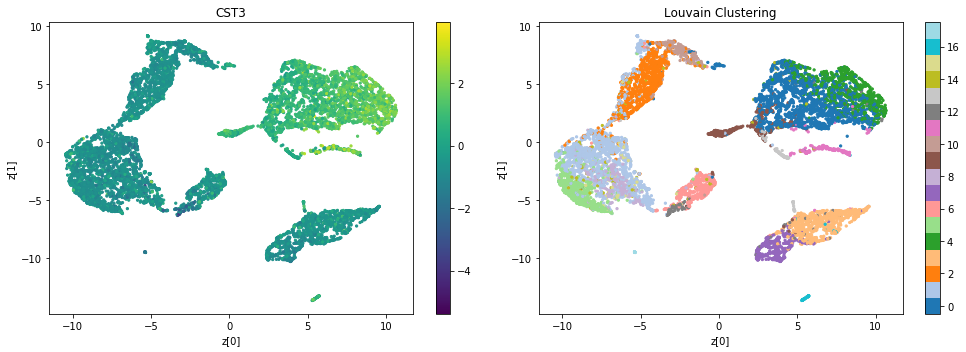

In [ ]:
# Training...

log_dir = '../results/AAE2/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

GRAPH = True
GENE = 'CST3'  # used only for training visualization

with strategy.scope():
    
    
    distributed_train_dataset = strategy.experimental_distribute_dataset(train_dataset)
    
    
    rec_loss, dis_loss, dis_cat_loss = model.distributed_train(distributed_train_dataset, strategy, 
                                                               enable_function=True, graph=GRAPH, gene=GENE, 
                                                               log_dir=log_dir)

In [19]:
#!tensorboard --logdir=../results/AAE2/PBMC10k/

In [ ]:
# Plot training loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
x_range = np.arange(1, model.epochs + 1, 1)
plt.plot(x_range, rec_loss, 'bo-')
plt.plot(x_range, dis_loss, 'ro-')
plt.plot(x_range, dis_cat_loss, 'go-')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Reconstruction', 'Discriminator', 'Cat. Discriminator'], loc='upper right')
plt.show()

In [ ]:
GENE_LIST = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score

# BUG: currently loading a model with multiple outpus generates an AttributeError
# log_dir = '../results/AAE2/PBMC10k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

labels_true = model.labels

model.update_labels(res=0.6)
labels_pred = model.labels

GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)

print("ARI = {}".format(adjusted_rand_score(labels_true, labels_pred)))
print("AMI = {}".format(adjusted_mutual_info_score(labels_true, labels_pred)))

## Variational Autoencoder

<img src="img/variational_autoencoder_model.png" width="800px" style="float:center">

### Build the model

In [4]:
# Network parameters
parameters = {
    'latent_dim': 40,
    'layers_enc_dim': [1000, 500, 300, 200, 100],
    'layers_dec_dim': [100, 200, 300, 500, 1000],
    'batch_size': 1000,
    'epochs': 5000
}

In [5]:
model = VAE(**parameters)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Dataset rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,1000,batch size
epochs,5000,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,None,weight of l2 kernel regularization
l1_weight,None,weight of l1 activity regularization
latent_dim,40,dimension of latent space Z
layer_1_enc_dim,1000,dimension of encoder dense layer 1


In [9]:
# Build the full model

# implement distribute strategy
TF_DISTRIBUTE_MIRRORED_STRATEGY = True
TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY = False

if TF_DISTRIBUTE_MIRRORED_STRATEGY:
    
#     CROSS_DEVICE_OPS = tf.distribute.HierarchicalCopyAllReduce()
#     CROSS_DEVICE_OPS = tf.distribute.ReductionToOneDevice()
    CROSS_DEVICE_OPS = tf.distribute.NcclAllReduce()
    
    mirrored_strategy = tf.distribute.MirroredStrategy(
        cross_device_ops=CROSS_DEVICE_OPS)
    
    with mirrored_strategy.scope():
        
        BATCH_SIZE_PER_REPLICA = model.batch_size
        global_batch_size = (BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync)
        model.batch_size = global_batch_size
        model.build_model()

# elif TF_DISTRIBUTE_CENTRAL_STORAGE_STRATEGY:
    
#     central_storage_strategy = tf.distribute.experimental.CentralStorageStrategy()
    
#     with central_storage_strategy.scope():
        
# #         BATCH_SIZE_PER_REPLICA = model.batch_size
# #         global_batch_size = (BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync)
# #         model.batch_size = global_batch_size
#         model.build_model()
    
else:
    model.build_model()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [10]:
# Model summary

model.get_summary()


Encoder Network
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  [(None, 2145)]       0                                            
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 1000)         2146000     X[0][0]                          
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 1000)         4000        H_1[0][0]                        
__________________________________________________________________________________________________
LR_1 (LeakyReLU)                (None, 1000)         0           BN_1[0][0]                       
___________________________________________________________________________

In [11]:
# Export model graphs

log_dir = '../results/VAE/PBMC10k/'
os.makedirs(log_dir + 'graphs', exist_ok=True)
model.export_graph('../results/VAE/PBMC10k/graphs')

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.
Model graphs saved.



### Visualize graphs

[ENCODER](../results/VAE/PBMC10k/graphs/encoder.png)

[DECODER](../results/VAE/PBMC10k/graphs/decoder.png)

[AUTOENCODER](../results/VAE/PBMC10k/graphs/autoencoder.png)

### Train the model

In [11]:
# Training...

log_dir = '../results/VAE/PBMC10k/'
os.makedirs(log_dir, exist_ok=True)

data_file = '../data/proc/pbmc10k.tfrecord'  # add for mode='TFRecord'

loss, val_loss = model.train(val_split=0.2, 
                             log_dir=log_dir, 
                             mode = 'TFRecord',
                             data_file=data_file, 
                             num_workers=24)

Start model training...
Train for 4 steps, validate for 1 steps
Epoch 1/5000
INFO:tensorflow:batch_all_reduce: 46 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 46 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
4/4 [==============================] - 17s 4s/step - loss: 2507.0236 - val_loss: 2516.4585
Epoch 2/5000
4/4 [==============================] - 0s 107ms/step - loss: 2386.0363 - val_loss: 2508.9209
Epoch 3/5000
4/4 [==============================] - 0s 108ms/step - loss: 2263.4612 - val_loss: 2506.0779
Epoch 4/5000
4/4 [==============================] - 0s 107ms/step - loss: 2173.2593 - val_loss: 2502.7637
Epoch 5/5000
4/4 [==============================] - 0s 107ms/step - loss: 2112.0198 - val_loss: 2494.4502
Epoch 6/5000
4/4 [==============================] - 0s 106ms/step - loss: 2067.8252 - val_loss: 2479.138

Epoch 71/5000
4/4 [==============================] - 0s 104ms/step - loss: 1807.6691 - val_loss: 1846.1890
Epoch 72/5000
4/4 [==============================] - 0s 109ms/step - loss: 1808.1607 - val_loss: 1846.4834
Epoch 73/5000
4/4 [==============================] - 0s 106ms/step - loss: 1802.9476 - val_loss: 1845.8306
Epoch 74/5000
4/4 [==============================] - 0s 106ms/step - loss: 1817.2957 - val_loss: 1845.2891
Epoch 75/5000
4/4 [==============================] - 0s 108ms/step - loss: 1795.2076 - val_loss: 1844.6567
Epoch 76/5000
4/4 [==============================] - 0s 107ms/step - loss: 1801.5812 - val_loss: 1844.2572
Epoch 77/5000
4/4 [==============================] - 0s 108ms/step - loss: 1802.6471 - val_loss: 1843.7944
Epoch 78/5000
4/4 [==============================] - 0s 108ms/step - loss: 1804.2139 - val_loss: 1842.9440
Epoch 79/5000
4/4 [==============================] - 0s 108ms/step - loss: 1801.8744 - val_loss: 1843.1741
Epoch 80/5000
4/4 [==================

4/4 [==============================] - 0s 106ms/step - loss: 1795.1573 - val_loss: 1828.6367
Epoch 148/5000
4/4 [==============================] - 0s 106ms/step - loss: 1780.5153 - val_loss: 1828.6467
Epoch 149/5000
4/4 [==============================] - 0s 108ms/step - loss: 1788.3148 - val_loss: 1828.9872
Epoch 150/5000
4/4 [==============================] - 0s 109ms/step - loss: 1792.3301 - val_loss: 1828.3629
Epoch 151/5000
4/4 [==============================] - 0s 108ms/step - loss: 1788.6432 - val_loss: 1828.0710
Epoch 152/5000
4/4 [==============================] - 0s 104ms/step - loss: 1796.0255 - val_loss: 1828.0621
Epoch 153/5000
4/4 [==============================] - 0s 107ms/step - loss: 1791.3022 - val_loss: 1827.4119
Epoch 154/5000
4/4 [==============================] - 0s 105ms/step - loss: 1793.5440 - val_loss: 1827.3868
Epoch 155/5000
4/4 [==============================] - 0s 105ms/step - loss: 1787.8979 - val_loss: 1827.0463
Epoch 156/5000
4/4 [=======================

Epoch 223/5000
4/4 [==============================] - 0s 108ms/step - loss: 1783.2004 - val_loss: 1819.1453
Epoch 224/5000
4/4 [==============================] - 0s 109ms/step - loss: 1777.5737 - val_loss: 1819.0032
Epoch 225/5000
4/4 [==============================] - 0s 108ms/step - loss: 1782.1407 - val_loss: 1818.7489
Epoch 226/5000
4/4 [==============================] - 0s 108ms/step - loss: 1782.5866 - val_loss: 1818.8218
Epoch 227/5000
4/4 [==============================] - 0s 105ms/step - loss: 1768.3351 - val_loss: 1818.6755
Epoch 228/5000
4/4 [==============================] - 0s 111ms/step - loss: 1769.0014 - val_loss: 1818.1882
Epoch 229/5000
4/4 [==============================] - 0s 104ms/step - loss: 1780.4658 - val_loss: 1818.3103
Epoch 230/5000
4/4 [==============================] - 0s 102ms/step - loss: 1769.7581 - val_loss: 1818.5354
Epoch 231/5000
4/4 [==============================] - 0s 103ms/step - loss: 1781.7738 - val_loss: 1818.4930
Epoch 232/5000
4/4 [========

Epoch 299/5000
4/4 [==============================] - 0s 110ms/step - loss: 1765.0853 - val_loss: 1814.9795
Epoch 300/5000
4/4 [==============================] - 0s 108ms/step - loss: 1771.3588 - val_loss: 1814.9169
Epoch 301/5000
4/4 [==============================] - 0s 108ms/step - loss: 1765.2149 - val_loss: 1814.7051
Epoch 302/5000
4/4 [==============================] - 0s 108ms/step - loss: 1773.9823 - val_loss: 1814.5662
Epoch 303/5000
4/4 [==============================] - 0s 106ms/step - loss: 1776.7840 - val_loss: 1814.6243
Epoch 304/5000
4/4 [==============================] - 0s 108ms/step - loss: 1772.6300 - val_loss: 1814.5471
Epoch 305/5000
4/4 [==============================] - 0s 109ms/step - loss: 1772.1516 - val_loss: 1814.6216
Epoch 306/5000
4/4 [==============================] - 0s 108ms/step - loss: 1773.8433 - val_loss: 1814.4596
Epoch 307/5000
4/4 [==============================] - 0s 106ms/step - loss: 1775.5868 - val_loss: 1814.5293
Epoch 308/5000
4/4 [========

Epoch 375/5000
4/4 [==============================] - 0s 105ms/step - loss: 1775.2908 - val_loss: 1811.9880
Epoch 376/5000
4/4 [==============================] - 0s 107ms/step - loss: 1765.0130 - val_loss: 1812.3083
Epoch 377/5000
4/4 [==============================] - 0s 106ms/step - loss: 1775.2144 - val_loss: 1812.1660
Epoch 378/5000
4/4 [==============================] - 0s 106ms/step - loss: 1766.4716 - val_loss: 1812.2443
Epoch 379/5000
4/4 [==============================] - 0s 106ms/step - loss: 1771.0896 - val_loss: 1812.0231
Epoch 380/5000
4/4 [==============================] - 0s 102ms/step - loss: 1755.5857 - val_loss: 1812.1858
Epoch 381/5000
4/4 [==============================] - 0s 107ms/step - loss: 1764.0781 - val_loss: 1812.1458
Epoch 382/5000
4/4 [==============================] - 0s 107ms/step - loss: 1763.4121 - val_loss: 1812.1702
Epoch 383/5000
4/4 [==============================] - 0s 107ms/step - loss: 1764.5976 - val_loss: 1812.1849
Epoch 384/5000
4/4 [========

Epoch 451/5000
4/4 [==============================] - 0s 106ms/step - loss: 1758.4285 - val_loss: 1810.6912
Epoch 452/5000
4/4 [==============================] - 0s 108ms/step - loss: 1759.7871 - val_loss: 1810.7249
Epoch 453/5000
4/4 [==============================] - 0s 106ms/step - loss: 1753.0235 - val_loss: 1810.4619
Epoch 454/5000
4/4 [==============================] - 0s 105ms/step - loss: 1767.0790 - val_loss: 1810.6260
Epoch 455/5000
4/4 [==============================] - 0s 106ms/step - loss: 1763.0664 - val_loss: 1810.5320
Epoch 456/5000
4/4 [==============================] - 0s 102ms/step - loss: 1767.0822 - val_loss: 1810.7212
Epoch 457/5000
4/4 [==============================] - 0s 106ms/step - loss: 1764.7060 - val_loss: 1810.6785
Epoch 458/5000
4/4 [==============================] - 0s 106ms/step - loss: 1763.8021 - val_loss: 1810.5712
Epoch 459/5000
4/4 [==============================] - 0s 107ms/step - loss: 1761.7590 - val_loss: 1810.6323
Epoch 460/5000
4/4 [========

Epoch 527/5000
4/4 [==============================] - 0s 105ms/step - loss: 1766.8240 - val_loss: 1809.5508
Epoch 528/5000
4/4 [==============================] - 0s 107ms/step - loss: 1758.3643 - val_loss: 1809.8733
Epoch 529/5000
4/4 [==============================] - 0s 107ms/step - loss: 1764.9414 - val_loss: 1809.7639
Epoch 530/5000
4/4 [==============================] - 0s 106ms/step - loss: 1754.9099 - val_loss: 1809.6647
Epoch 531/5000
4/4 [==============================] - 0s 109ms/step - loss: 1771.7330 - val_loss: 1809.5067
Epoch 532/5000
4/4 [==============================] - 0s 107ms/step - loss: 1748.9572 - val_loss: 1809.5062
Epoch 533/5000
4/4 [==============================] - 0s 107ms/step - loss: 1758.4650 - val_loss: 1809.7100
Epoch 534/5000
4/4 [==============================] - 0s 108ms/step - loss: 1756.2644 - val_loss: 1809.6272
Epoch 535/5000
4/4 [==============================] - 0s 107ms/step - loss: 1753.1973 - val_loss: 1809.9261
Epoch 536/5000
4/4 [========

Epoch 603/5000
4/4 [==============================] - 0s 110ms/step - loss: 1756.8604 - val_loss: 1809.3656
Epoch 604/5000
4/4 [==============================] - 0s 110ms/step - loss: 1747.1138 - val_loss: 1809.1663
Epoch 605/5000
4/4 [==============================] - 0s 107ms/step - loss: 1754.0318 - val_loss: 1809.4995
Epoch 606/5000
4/4 [==============================] - 0s 109ms/step - loss: 1747.9350 - val_loss: 1809.3137
Epoch 607/5000
4/4 [==============================] - 0s 107ms/step - loss: 1764.2435 - val_loss: 1809.4579
Epoch 608/5000
4/4 [==============================] - 0s 107ms/step - loss: 1758.6603 - val_loss: 1809.1975
Epoch 609/5000
4/4 [==============================] - 0s 104ms/step - loss: 1756.4404 - val_loss: 1809.0852
Epoch 610/5000
4/4 [==============================] - 0s 106ms/step - loss: 1754.2307 - val_loss: 1809.1450
Epoch 611/5000
4/4 [==============================] - 0s 105ms/step - loss: 1756.8504 - val_loss: 1809.3868
Epoch 612/5000
4/4 [========

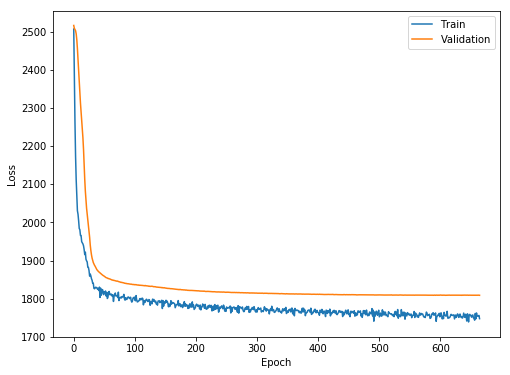

In [13]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(loss)
plt.plot(val_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

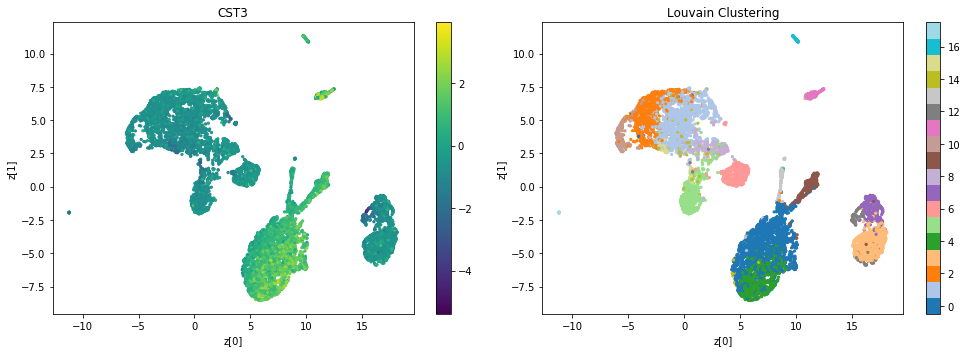

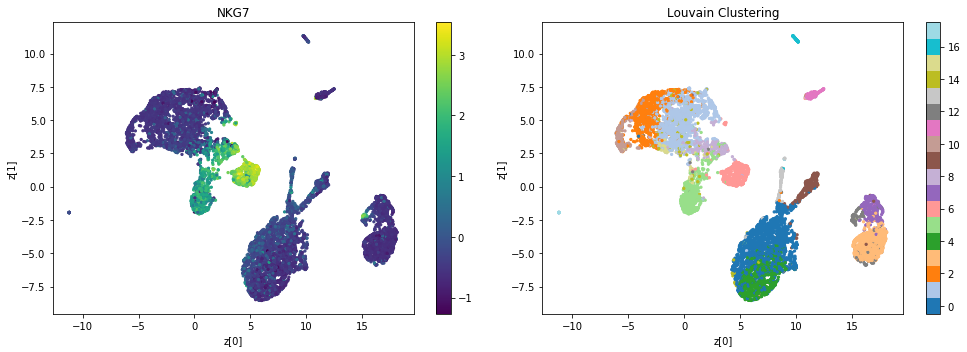

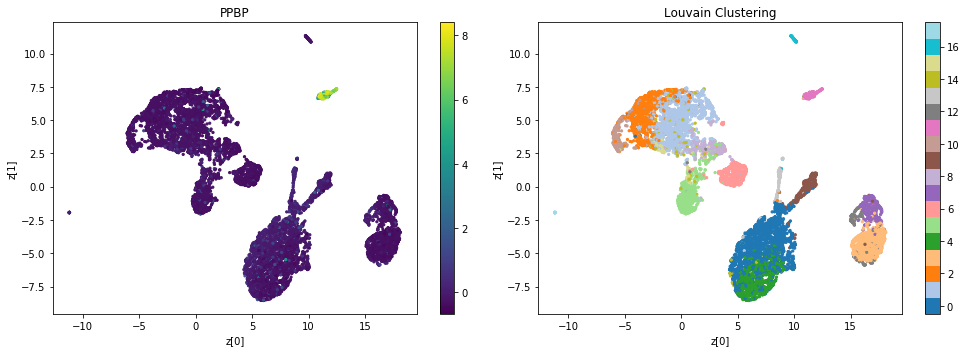

In [14]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

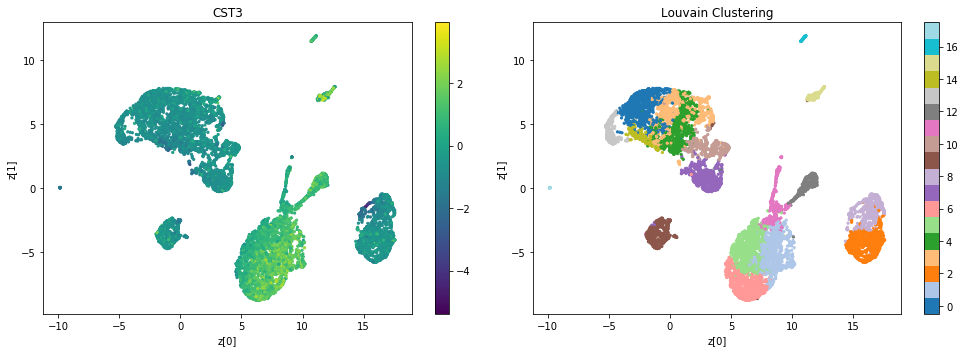

In [22]:
from tensorflow.keras.models import load_model

log_dir = '../results/VAE/PBMC10k/'
# model.encoder = load_model(log_dir + 'models/encoder.h5')

model.update_labels(res=0.82)

GENE_LIST = ['CST3']
model.plot_umap(gene_selected=GENE_LIST, louvain=True)